In [22]:
# ================================
# !!! DEGRADE IRF THROUGH AEFF !!!
# ================================

# IMPORTS ---!
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from module_plot import degradedIRF_3d
from module_analysis import degrade_IRF
from pkg_blindsearch import *

import os
import sys
import subprocess

# check permissions ---!
if os.geteuid() == 0:
    print("We're root!")
else:
    print("We're not root.")

# setup ---!
pathout = '/usr/local/gamma/share/caldb/data/cta/degr3b/bcf/'
pathin = '/usr/local/gamma/share/caldb/data/cta/prod3b/bcf/'
folder = 'South_z20_average_100s/'
irf = pathin + folder + 'irf_file.fits'
degraded_irf = pathout + folder + 'irf_file.fits'

with fits.open(irf) as hdul :
    aeff = hdul['EFFECTIVE AREA'].data['EFFAREA'][:]
    bkg = hdul['BACKGROUND'].data['BKG'][:]
#    print(list(hdul[4].header.values()))

tObj = analysis('/config.xml')
tObj.irf = folder
tObj.caldb = 'prod3b'
tObj.degradeIRF()

with fits.open(degraded_irf) as hdul :
    aeff2 = hdul['EFFECTIVE AREA'].data['EFFAREA'][:]
    bkg2 = hdul['BACKGROUND'].data['BKG'][:]

print(aeff.shape, aeff2.shape, bkg.shape, bkg2.shape)
print(aeff.max(), aeff2.max(), bkg.max(), bkg2.max())

We're not root.


CalledProcessError: Command '['sudo', 'chmod', '-R', '777', '/usr/local/gamma/share/caldb/data/cta/']' returned non-zero exit status 1.

(6, 42) (6, 42) (6, 42)


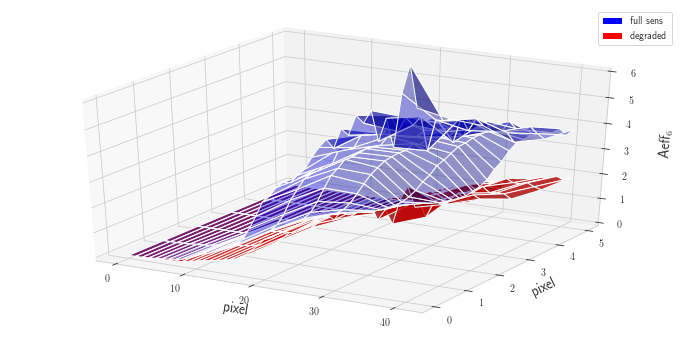

done


In [2]:
# ====================
# !!! PLOT AEFF 3D !!!
# ====================

from mpl_toolkits.mplot3d import Axes3D

impath = './irf_degraded/South_z40_average_100s/'

savefig = impath + 'IRF_degrading_Aeff.png'
savefiga = impath + 'IRF_degrading_Aeff_nominal.png'
savefigb = impath + 'IRF_degrading_Aeff_degraded.png'
fontsize=14
plt.rc('text', usetex=True)
sns.set_style("whitegrid", {'axes.grid' : False})

x = np.array(range(len(aeff[:][0])))
y = np.array(range(len(aeff[0][0][:])))
xx, yy = np.meshgrid(y, x)

aeff_flat = aeff[0]
aeff2_flat = aeff2[0]
print(xx.shape, yy.shape, aeff_flat.shape)

degradedIRF_3d(xx, yy, [aeff_flat/1e6, aeff2_flat/1e6], xlabel='pixel', ylabel='pixel', 
               zlabel='Aeff$_6$', title=None, fontsize=fontsize, zlim=(0,6), alpha=[0.4, 0.8], 
               c=['b', 'r'], label=['full sens', 'degraded'], savefig=savefig)

degradedIRF_3d(xx, yy, [aeff_flat/1e6], xlabel='pixel', ylabel='pixel', 
               zlabel='Aeff$_6$', title=None, fontsize=fontsize, zlim=(0,6), alpha=[0.8], 
               c=['b'], label=['full sens'], savefig=savefiga, show=False)

degradedIRF_3d(xx, yy, [aeff2_flat/1e6], xlabel='pixel', ylabel='pixel', 
               zlabel='Aeff$_6$', title=None, fontsize=fontsize, zlim=(0,6), alpha=[0.8], 
               c=['r'], label=['degraded'], savefig=savefigb, show=False)

print('done')

In [17]:
# ===================
# !!! PLOT BKG 3D !!!
# ===================

from PIL import Image

x = np.array(range(len(bkg[0][0][0])))
y = np.array(range(len(bkg[0][0][:])))
xx, yy = np.meshgrid(y, x)
bkg_flat = bkg[0]
bkg2_flat = bkg2[0]
print(x.shape, y.shape, xx.shape, bkg_flat.shape, bkg2_flat.shape)

imgs = []
imgsa = []
imgsb = []
frames = []
for i in range(21) :
    savefig2 = './irf_degraded/frames/IRF_degrading_Bkg%02d.png' %(i+1)
    imgs.append(savefig2)
    degradedIRF_3d(xx, yy, [bkg_flat[-(i+1)], bkg2_flat[-(i+1)]], xlabel='pixel', ylabel='pixel', 
                   zlabel='Bkg (1/MeV/s/sr)', title='Frame %d' %(i+1), fontsize=fontsize, alpha=[0.4, 0.6], 
                   c=['b', 'r'], label=['full sens', 'degraded'], savefig=savefig2, 
                   zlim=(0, bkg_flat[-(i+1)].max()), show=False)
    
    savefig2a = './irf_degraded/frames/IRF_degrading_Bkg%02d_nominal.png' %(i+1)
    imgsa.append(savefig2a)
    degradedIRF_3d(xx, yy, [bkg_flat[-(i+1)]], xlabel='pixel', ylabel='pixel', 
                   zlabel='Bkg (1/MeV/s/sr)', title='Frame %d' %(i+1), fontsize=fontsize, alpha=[0.8], 
                   c=['b'], label=['full sens'], savefig=savefig2a, 
                   zlim=(0, bkg_flat[-(i+1)].max()), show=False)
    
    savefig2b = './irf_degraded/frames/IRF_degrading_Bkg%02d_degraded.png' %(i+1)
    imgsb.append(savefig2b)
    degradedIRF_3d(xx, yy, [bkg2_flat[-(i+1)]], xlabel='pixel', ylabel='pixel', 
                   zlabel='Bkg (1/MeV/s/sr)', title='Frame %d' %(i+1), fontsize=fontsize, alpha=[0.8], 
                   c=['r'], label=['degraded'], savefig=savefig2b, 
                   zlim=(0, bkg_flat[-(i+1)].max()), show=False)
    
for im in imgs:
    new_frame = Image.open(im)
    frames.append(new_frame)

# Save into a GIF file that loops forever ---!
frames[0].save(impath + 'IRF_degrading_Bkg.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)
frames = []
for im in imgsa:
    new_frame = Image.open(im)
    frames.append(new_frame)

# Save into a GIF file that loops forever ---!
frames[0].save(impath + 'IRF_degrading_Bkg_nominal.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

frames = []
for im in imgsb:
    new_frame = Image.open(im)
    frames.append(new_frame)

# Save into a GIF file that loops forever ---!
frames[0].save(impath + 'IRF_degrading_Bkg_degraded.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

print('done')


(36,) (36,) (36, 36) (21, 36, 36) (21, 36, 36)
done


In [14]:
from IPython.display import Image
Image(url='./irf_degraded/South_z40_average_100s/IRF_degrading_Bkg_nominal.gif') 

In [16]:
Image(url='./irf_degraded/South_z40_average_100s/IRF_degrading_Bkg_degraded.gif') 